<a href="https://colab.research.google.com/github/hyunj941031/ds-sa-cp2/blob/main/models/MF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install python-box

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 32.1 MB/s eta 0:00:00


In [53]:
import numpy as np
import pandas as pd

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
from collections import defaultdict
from box import Box

import warnings

warnings.filterwarnings(action='ignore')

In [54]:
config = {
    'data_path' : '/content/drive/MyDrive/fashion_campus_dataset',
}

args = {
    "batch_size": 256,
    "dropout": 0.0,
    "epochs": 20,
    "num_factor": 32,
    "gpu": "0",
    "lr": 0.001,
    "num_layers": 3,
    "num_ng": 4,
    "out": True,
    "test_num_ng": 99,
    "top_k": 15,
}

config = Box(config)
# os.environ["CUDA_VISIBLE_DEVICES"] = args["gpu"]
# cudnn.benchmark = True

In [56]:
df = pd.read_csv(os.path.join(config['data_path'], 'user_item.csv'), index_col=0)
df.tail()

,userId,itemId,timestamp
1254580,99998,18523,1643072049
1254581,99998,44211,1643072049
1254582,99998,16555,1643072049
1254583,99998,20236,1643072049
1254584,99999,52193,1476300141


In [61]:
class SplitData():
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'user_item.csv'))
        self.user_train, self.user_valid = self.split_sequence_data()

    def split_sequence_data(self) -> dict:
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        group_df = self.df.groupby('userId')
        for user, item in group_df:
            users[user].extend(item['itemId'].tolist())

        for user in users:
            user_train[user] = users[user][:-1]
            user_valid[user] = [users[user][-1]] # 마지막 아이템 예측

        return user_train, user_valid

    def get_train_valid_data(self):
        return self.user_train, self.user_valid

split_data = SplitData(config)
train_df, val_df = split_data.get_train_valid_data()

In [65]:
num_user = df['userId'].nunique()
num_item = df['itemId'].nunique()

sparsity = 1 - len(df) / (num_user * num_item)

print(f'전체 User 수: {num_user}')
print(f'전체 Item 수: {num_item}')
print(f'행렬의 희소성: {sparsity:.4f}')

전체 User 수: 50705
전체 Item 수: 44446
행렬의 희소성: 0.9994


In [29]:
not_in_val_user_num = len(set(val_df['userId'].unique().tolist()) - set(train_df['userId'].unique().tolist()))
not_in_val_item_num = len(set(val_df['itemId'].unique().tolist()) - set(train_df['itemId'].unique().tolist()))

print(f'학습용 데이터에 없는 유저의 수 : {not_in_val_user_num}')
print(f'학습용 데이터에 없는 상품의 수 : {not_in_val_item_num}')
print(f'학습용 데이터의 수: {len(train_df)}, 평가용 데이터의 수: {len(val_df)}')

학습용 데이터에 없는 유저의 수 : 903
학습용 데이터에 없는 상품의 수 : 0
학습용 데이터의 수: 1129617, 평가용 데이터의 수: 124968


In [30]:
user_encoder, user_decoder = {}, {}
for idx, user_id in enumerate(df['userId'].unique()):
    user_encoder[user_id] = idx
    user_decoder[idx] = user_id

item_encoder, item_decoder = {}, {}
for idx, item_id in enumerate(df['itemId'].unique()):
    item_encoder[item_id] = idx
    item_decoder[idx] = item_id

Text(0.5, 1.0, 'Item distribution')

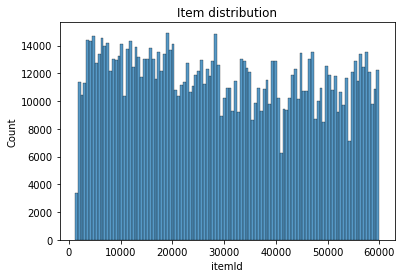

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['itemId'])
plt.title('Item distribution')

In [32]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, user_encoder, item_encoder):
        self.df = df
        self.user_encoder, self.item_encoder, = user_encoder, item_encoder
        self.user = torch.tensor([self.user_encoder[i] for i in self.df['userId'].tolist()])
        self.item = torch.tensor([self.item_encoder[i] for i in self.df['itemId'].tolist()])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = self.user[idx]
        item = self.item[idx]

        return user, item

In [33]:
from matplotlib import path
class MF(nn.Module):
    def __init__(self, num_user, num_item, num_factor, dropout model):
        super(MF, self).__init__()
        self.dropout = dropout
        self.model = model
        self.num_factor = num_factor

        self.emb_user = nn.Embedding(num_user, num_factor)
        self.emb_item = nn.Embedding(num_item, num_factor)
        predict_size = num_factor

        self.predict_layer = torch.ones(predict_size, 1).cuda()
        self._init_weight_()

    def _init_weight(self):
        # weight 초기화
        nn.init.normal_(self.emb_user.weight, std=0.01)
        nn.init.normal_(self.emb_item.weight, std=0.01)

        # bias 초기화
        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()

    def forward(self, user, item):
        p_u = self.P(user)
        q_i = self.Q(item)
        b_u = self.user_bias(user)
        b_i = self.item_bias(item)

        output = torch.sum((p_u * q_i), axis = 1) + torch.squeeze(b_u) + torch.squeeze(b_i)
        
        return output.view(-1)

In [34]:
def train(model, train_loader):
    model.train()
    train_loss = 0

    for user, item in train_loader:
        user = user.to(device)
        item = item.to(device)

        optimizer.zero_grad()
        output = model(user, item)

        loss = criterion(output, item)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)

    return train_loss


def evaluate(model, test_loader):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for user, item, rating in test_loader:
            user = user.to(device)
            item = item.to(device)

            output = model(user, item)

            loss = criterion(output, item)

            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)

    return test_loss

In [35]:
num_factor = 100
batch_size = 128
epochs = 30
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lr = 0.005

In [36]:
model = MF(num_user = num_user, num_item = num_item, num_factor = num_factor).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

train_dataset = CustomDataset(df = df, user_encoder = user_encoder, item_encoder = item_encoder)
val_dataset = CustomDataset(df = val_df, user_encoder = user_encoder, item_encoder = item_encoder)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, drop_last = False)

In [37]:
best_metric = 1

for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader)
    val_loss = evaluate(model, val_loader)

    print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_metric:
        best_metric = val_loss
        torch.save(model.state_dict(), model_dir + f'Matrix_Factorization.pt')

RuntimeError: ignored